In [1]:
import numpy as np
import os
import sys
import h5py
import datetime
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from embeddings import Embeddings

Using TensorFlow backend.


EMBEDDING(100,4,1,4) STARTED .....
Loading embeddings....
Loading Squad Data
Loading Squad Training Data
Loading Squad Dev Data
Combining Squad Data
Loading the embeddings from the cache
Starting tokenized, pos squad data.....
Combining Squad Data
Creating Tokenized Squad Corpus
Creating Tokenized Squad Corpus
EMBEDDING(100,4,1,4) COMPLETED .....


## Setting Parameters

PLease remove the errors, fiilup all the variables.

In [10]:
model_name = LAYER_NAME + loss_function + "_"+ str(custom_accuracy) + "_" + activation + "_" + str(window_size) + "_" + str(batch_size) #MODEL_NAME #POS-LSTM

NameError: name 'LAYER_NAME' is not defined

In [8]:
word_embedding_dimension = 100
word_embedding_window_size = 4
batch_size = 128 #BATCH_SIZE # 32, 64, 128
epochs = 10 #EPOCH_SIZE # 10, 15, 30
window_size = 3 #WINDOW_SIZE # 3, 4, 5
accuracy_threshold = 0.85
activation = 'relu' #ACTIVATION_FUNCTION # sigmoid, relu, softmax
custom_accuracy = 0
loss_function = 'mse' #LOSS_FUNCTION # mse

In [9]:
model_name

'POS-LSTM_mse_0_relu_3_128'

In [3]:
embeddings = Embeddings(word_embedding_dimension, word_embedding_window_size, 1, 4)
tokenized_pos_sentences = embeddings.get_pos_categorical_indexed_sentences()
pos2index, index2pos = embeddings.get_pos_vocabulary()
no_of_unique_tags = len(pos2index)


Loading the embeddings from the cache


In [4]:
seq_in = []
seq_out = []
# generating dataset
for sentence in tokenized_pos_sentences:
    for i in range(len(sentence)-window_size-1):
        x = sentence[i:i + window_size]
        y = sentence[i + window_size]
        seq_in.append(x)
        seq_out.append(y)
# converting seq_in and seq_out into numpy array
seq_in = np.array(seq_in)
seq_out = np.array(seq_out)
n_samples = len(seq_in)
print ("Number of samples : ", n_samples)

Number of samples :  68424


In [5]:
x_data = seq_in
y_data = seq_out

In [211]:
# Changes to the model to be done here
model = Sequential()
model.add(LSTM(512, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(512))
#model.add(Dropout(0.2))
model.add(Dense(no_of_unique_tags, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 512)            1089536   
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 19)                9747      
Total params: 3,198,483
Trainable params: 3,198,483
Non-trainable params: 0
_________________________________________________________________


In [215]:
model_weights_path = "../weights/"+ model_name
if not os.path.exists(model_weights_path):
    os.makedirs(model_weights_path)
checkpoint_path = model_weights_path + '/pos_weights.{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [217]:
model.fit(x_data[:100], y_data[:100], epochs=5, batch_size=128, verbose=1, validation_split=0.25, callbacks=[checkpoint])

Train on 75 samples, validate on 25 samples
Epoch 1/1
Epoch 00000: saving model to ../weights/POS_LSTM_512_512_02drop_relu_128_3ws/pos_weights.00-0.40.hdf5
75/75 [==============================] - 0s - loss: 1.9194 - acc: 0.3333 - val_loss: 2.0313 - val_acc: 0.4000


In [224]:
check_ori = 0
check_pre = 0
counter = 0
test_start = 0
test_end = 50
list_for_hist_words = []
list_for_hist_index = []
list_for_hist_words_ori = []
list_for_hist_index_ori = []
for i in range(test_start, test_end):
    test_no = i
    to_predict = x_data[test_no:test_no+1]
    y_ans = model.predict(to_predict)
    
    for word, corr_int in pos2index.items():
        if corr_int == np.argmax(y_ans):
            #print ("pridicted: ",word, corr_int)
            check_pre = corr_int
            list_for_hist_words.append(word)
            list_for_hist_index.append(corr_int)
        if corr_int == np.argmax(y_data[test_no:test_no+1]):
            #print ("original: ",word, corr_int)
            check_ori = corr_int
            list_for_hist_words_ori.append(word)
            list_for_hist_index_ori.append(corr_int)
    if check_ori == check_pre :
        counter += 1
    #print('\n')

print("Correct predictions: ",counter, '\nTotal Predictions: ',test_end - test_start)

Correct predictions:  14 
Total Predictions:  50


In [220]:
import matplotlib.pyplot as plt
%matplotlib inline

In [221]:
pos_vocab = [v for (k,v) in index2pos.items()]

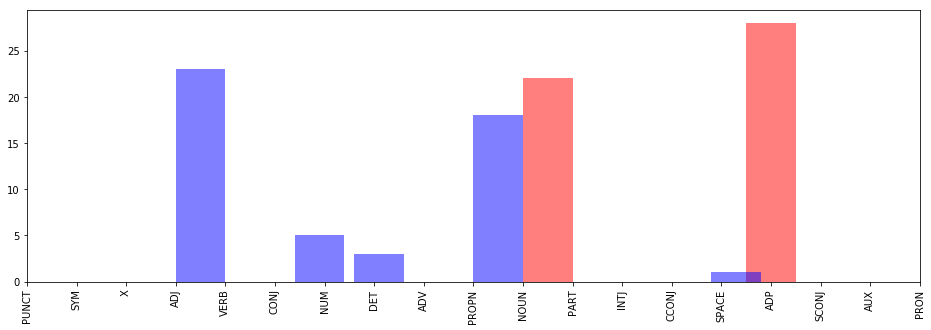

In [223]:
plt.figure(figsize=(16,5))
plt.hist(list_for_hist_index, width=1, color='r', alpha=0.5)
plt.hist(list_for_hist_index_ori, width=1, color='b', alpha=0.5)
plt.xticks(range(len(pos_vocab)),pos_vocab, rotation='vertical')
plt.show()

In [109]:
list_x = []
list_y = []
data_all = []
for i in range(0,1500):
    list_x.append((index2pos[np.argmax(x_data[i][0])], index2pos[np.argmax(x_data[i][1])]))
    list_y.append(index2pos[np.argmax(y_data[i])])
    data_all.append((str(list_x[i]),list_y[i]))

In [113]:
from nltk import ConditionalFreqDist as cfd
from nltk.collocations import *
import plotly.offline as plot
import plotly.graph_objs as go
plot.offline.init_notebook_mode(connected=True)
import pandas as pd

In [114]:
cfd_res = cfd(data_all)

In [116]:
df = pd.DataFrame(cfd_res).fillna(0)
mat = df.as_matrix()
#mat

In [117]:
trace = go.Heatmap(z = mat,
                   x=df.columns,
                   y=list(df.index))
data=[trace]
plot.iplot(data, filename='labelled-heatmap')